In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

import gym_env
from models import LinearRL_NHB

### Make simple environment and transition policies

In [3]:
## Construct a simple environment
envstep=[]
for s in range(3):
    # actions 0=left, 1=right
    envstep.append([[0,0], [0,0]])  # [s', done]
envstep = np.array(envstep)
# State 0 -> 1, 2
envstep[0,0] = [1,0]
envstep[0,1] = [2,0]

# State 1 -> 3
envstep[1,0] = [3,1]
envstep[1,1] = [3,1]

# State 2 -> 4
envstep[2,0] = [4,1]
envstep[2,1] = [4,1]

## Construct a biased policy
T_b = np.zeros((5,5))
# State 3 is more rewarding than state 4 so we will incorporate that preference into the policy
T_b[0,1] = 0.8
T_b[0,2] = 0.2
T_b[1,3] = 1.0
T_b[2,4] = 1.0
T_b[3,3] = 1.0
T_b[4,4] = 1.0

## The unbiased transition policy
T = np.zeros((5,5))
T[0,1] = 0.5
T[0,2] = 0.5
T[1,3] = 1.0
T[2,4] = 1.0
T[3,3] = 1.0
T[4,4] = 1.0

In [4]:
def softmax(state, T, V, envstep):
    successor_states = np.where(T[state, :] != 0)[0]
    action_probs = np.full(2, 0.0)   # We can hardcode this because every state has 2 actions

    v_sum = sum(np.exp(V[s] / 1.0) for s in successor_states)

    # if we don't have enough info, random action
    if v_sum == 0:
        return  np.random.choice([0,1])

    for action in [0,1]:
        new_state, done = envstep[state, action]

        # If we hit a done state our action doesn't matter
        if done:
            action = np.random.choice([0,1])
            return action, 1
        action_probs[action] = np.exp(V[new_state] / 1.0 ) / v_sum
        
    action = np.random.choice([0,1], p=action_probs)
    s_prob = action_probs[action]

    return action, s_prob

def imp_sampling(T, state, s_prob):
    successor_states = np.where(T[state, :] != 0)[0]
    p = 1/len(successor_states)
    w = p/s_prob
            
    return w

def train_SR(num_steps, alpha, gamma, r, imp_samp):
    M = np.eye(5)
    one_hot = np.eye(5)
    state = 0
    diffs = []
    for _ in range(num_steps):
        V = M @ r
        action, s_prob = softmax(state, T, V, envstep)
        if imp_samp:
            w = imp_sampling(T, state, s_prob)
        else:
            w = 1

        # Take action
        next_state, done = envstep[state, action]

        # Update SR
        target = one_hot[state] + gamma * M[next_state]
        M[state] = (1 - alpha) * M[state] + alpha * target * w

        diffs.append(np.square(M[0][1] - M[0][2]))

        if done:
            state = 0
            continue
        
        state = next_state
    
    return M, diffs

### Train SR agents

In [5]:
# Define parameters
num_steps = 12000
num_simulations = 20
alpha = 0.01
gamma = 0.3
# seed = 96
r = np.array([0,0,0,10,2])

In [6]:
diffs_all_without, diffs_all_with = [], []
for seed in np.arange(num_simulations):
    np.random.seed(int(seed))
    M_without, diffs_without = train_SR(num_steps, alpha, gamma, r, imp_samp=False)
    M_with, diffs_with = train_SR(num_steps, alpha, gamma, r, imp_samp=True)
    diffs_all_without.append(diffs_without)
    diffs_all_with.append(diffs_with)
    print(f"seed: {seed}")
    print(M_without[0][1], M_without[0][2])
    print(M_with[0][1], M_with[0][2])

seed: 0
0.2788467425026534 0.021153257497346582
0.15096956067083983 0.13925578114505333
seed: 1
0.2663143114958687 0.03368568850413117
0.14997434740786902 0.1503096236913516
seed: 2
0.2771164874777773 0.022883512522222798
0.14821587348672283 0.16980007174607076
seed: 3
0.28396963258772934 0.016030367412270527
0.14895987783576103 0.16153771829088603
seed: 4
0.26557911247607685 0.034420887523923145
0.15224931202798292 0.1250673043555365
seed: 5
0.27593014390094417 0.02406985609905588
0.15045827565433412 0.14492758857098764
seed: 6
0.2814349184994334 0.018565081500566516
0.1496058706917903 0.15437396882874868
seed: 7
0.2775565216625235 0.022443478337476456
0.1523104780573019 0.12439276231604918
seed: 8
0.28418433862671677 0.01581566137328315
0.15355484518610554 0.11063130168876852
seed: 9
0.278340728852716 0.0216592711472839
0.14999209067832478 0.15010078139679753
seed: 10
0.2779140686499787 0.022085931350021647
0.15115331993665315 0.13723117936780588
seed: 11
0.2692128953073826 0.0307871

In [9]:
M_with

array([[1.0427805 , 0.14872819, 0.16410596, 0.04461846, 0.04872161],
       [0.        , 1.        , 0.        , 0.3       , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.29716958],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [10]:
M_without

array([[1.        , 0.27888938, 0.02111062, 0.08366681, 0.00629401],
       [0.        , 1.        , 0.        , 0.3       , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.29828758],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [7]:
import seaborn as sns
palette = sns.color_palette("colorblind")

print(palette)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921568627451, 0.5803921568627451), (0.9254901960784314, 0.8823529411764706, 0.2), (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]


In [75]:
palette[4]

(0.8, 0.47058823529411764, 0.7372549019607844)

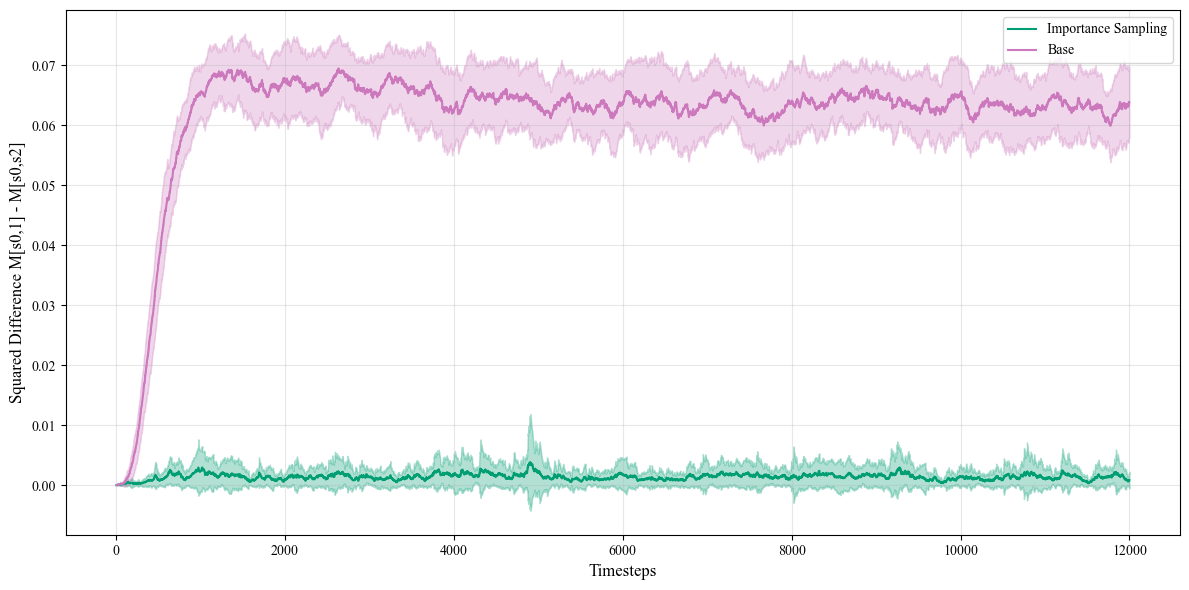

In [73]:
# Convert lists to numpy arrays for easier calculations
arr_with = np.array(diffs_all_with)
arr_without = np.array(diffs_all_without)

# Calculate means and standard deviations
mean_with = np.mean(arr_with, axis=0)
std_with = np.std(arr_with, axis=0)
mean_without = np.mean(arr_without, axis=0)
std_without = np.std(arr_without, axis=0)

# Create x-axis (timesteps)
timesteps = np.arange(1, 12001)

# Set up the plot style
# plt.style.use('classic')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot mean and variance for 'with' data
ax.plot(timesteps, mean_with, label='Importance Sampling', color=palette[2])
ax.fill_between(timesteps, mean_with - std_with, mean_with + std_with, 
                alpha=0.3, color=palette[2])

# Plot mean and variance for 'without' data
ax.plot(timesteps, mean_without, label='Base', color=palette[4])
ax.fill_between(timesteps, mean_without - std_without, mean_without + std_without, 
                alpha=0.3, color=palette[4])

# Customize the plot
ax.set_xlabel('Timesteps', fontsize=12)
ax.set_ylabel('Squared Difference M[s0,1] - M[s0,s2]', fontsize=12)
# ax.set_title('Mean and Variance of Squared Error Over Time', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Adjust tick label font size
ax.tick_params(axis='both', which='major', labelsize=10)

# Set background color to light gray for better contrast
# ax.set_facecolor('#F0F0F0')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

### Analysis for figure 1

In [80]:
M_with = np.array([
    [0, 0.5, 0.5, 0, 0],
    [0, 1, 0, 0.2, 0],
    [0, 0, 1, 0, 0.3],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1]
])

M_without= np.copy(M_with)
r = np.array([0,0,0,10,2])
V = M_with @ r
print(V)
print(np.exp(V[1]) / (np.exp(V[1]) + np.exp(V[2])))

[ 0.   2.   0.6 10.   2. ]
0.8021838885585817


In [81]:
alpha = 0.3
gamma = 1.0
r = np.array([0,0,0,10,2])

state = 0
one_hot = np.eye(5)
num_actions = 30
actions = [0, 0, 1, 0, 0]
next_states = [1,2]

# Holders for data
base_s0s1, base_s0s2, impsamp_s0s1, impsamp_s0s2 = [], [], [], [] 
target_base_s0s1, target_base_s0s2, target_impsamp_s0s1, target_impsamp_s0s2 = [], [], [], [], 

print("Beginning...")
print(f"M_with[s0]: {M_with[0]}")
print(f"M_without[s0]: {M_without[0]} \n")

base_s0s1.append(M_without[0,1])
base_s0s2.append(M_without[0,2])
impsamp_s0s1.append(M_with[0,1])
impsamp_s0s2.append(M_with[0,2])

target_base_s0s1.append(0)
target_base_s0s2.append(0)
target_impsamp_s0s1.append(0)
target_impsamp_s0s2.append(0)

for i, action in enumerate(actions):
    V_with = M_with @ r
    V_without = M_without @ r

    # Take action
    next_state, _ = envstep[state, action]

    # get probabilities of taking the action
    prob_with = np.exp(V_with[next_states[action]]) / (np.exp(V_with[next_states[action]]) + np.exp(V_with[next_states[1-action]]))

    # Importance sampling
    w = imp_sampling(T, state, prob_with)

    # Update base SR
    target_without = one_hot[state] + gamma * M_without[next_state]
    M_without[state] = (1 - alpha) * M_without[state] + alpha * target_without

    # Update importance sampling
    target_with = one_hot[state] + gamma * M_with[next_state]
    M_with[state] = (1 - alpha) * M_with[state] + alpha * target_with * w

    print(f"Action: {action}")
    print(f"M_with[s0]: {M_with[0]} | w: {w}")
    print(f"M_without[s0]: {M_without[0]}")
    print(f"target base: {target_with} | target importance: {target_with * w}\n")

    # Update data holders
    base_s0s1.append(M_without[0,1])
    base_s0s2.append(M_without[0,2])
    impsamp_s0s1.append(M_with[0,1])
    impsamp_s0s2.append(M_with[0,2])

    target_base_s0s1.append(target_with[1])
    target_base_s0s2.append(target_with[2])
    target_impsamp_s0s1.append(target_with[1]*w)
    target_impsamp_s0s2.append(target_with[2]*w)

print("Final:")
print(f"M_with[s0]: {M_with[0]}")
print(f"M_without[s0]: {M_without[0]} \n")
data_s0s1 = [base_s0s1, impsamp_s0s1, target_base_s0s1, target_impsamp_s0s1]
data_s0s2 = [base_s0s2, impsamp_s0s2, target_base_s0s2, target_impsamp_s0s2]

Beginning...
M_with[s0]: [0.  0.5 0.5 0.  0. ]
M_without[s0]: [0.  0.5 0.5 0.  0. ] 

Action: 0
M_with[s0]: [0.18698954 0.53698954 0.35       0.03739791 0.        ] | w: 0.6232984819708033
M_without[s0]: [0.3  0.65 0.35 0.06 0.  ]
target base: [1.  1.  0.  0.2 0. ] | target importance: [0.62329848 0.62329848 0.         0.1246597  0.        ]

Action: 0
M_with[s0]: [0.31788223 0.56288223 0.245      0.06357645 0.        ] | w: 0.6232984819708033
M_without[s0]: [0.51  0.755 0.245 0.102 0.   ]
target base: [1.  1.  0.  0.2 0. ] | target importance: [0.62329848 0.62329848 0.         0.1246597  0.        ]

Action: 1
M_with[s0]: [0.98079755 0.39401756 0.92978    0.04450351 0.227484  ] | w: 2.5275999834223377
M_without[s0]: [0.657  0.5285 0.4715 0.0714 0.09  ]
target base: [1.  0.  1.  0.  0.3] | target importance: [2.52759998 0.         2.52759998 0.         0.75828   ]

Action: 0
M_with[s0]: [0.87354783 0.46280184 0.650846   0.06855037 0.1592388 ] | w: 0.6232984819708033
M_without[s0]: [0.7

### Plots

In [95]:
def plot_data(data, title, legend=True):
    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define colors
    colors = [
        (0.8, 0.47058823529411764, 0.7372549019607844),  # base
        (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),  # importance sampling
        'salmon',  # target - base
        (0.8, 0.8, 1.0)  # target - importance sampling (periwinkle)
    ]
    
    labels = ['Base', 'Importance Sampling', 'Target - Base', 'Target - Importance Sampling']
    
    # Set width of each bar and positions
    bar_width = 0.2
    num_actions = len(data[0])
    
    for i, (values, color, label) in enumerate(zip(data, colors, labels)):
        positions = np.arange(num_actions) + i * bar_width
        plt.bar(positions, values, color=color, edgecolor='black', width=bar_width, label=label)
    
    # Labeling
    plt.xlabel('Action Steps', fontweight='bold')
    plt.ylabel('Values', fontweight='bold')
    plt.title(title, fontweight='bold')
    plt.xticks(np.arange(num_actions) + bar_width*1.5, [f'Action {i}' for i in range(num_actions)])
    
    # Create legend
    if legend:
        plt.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()

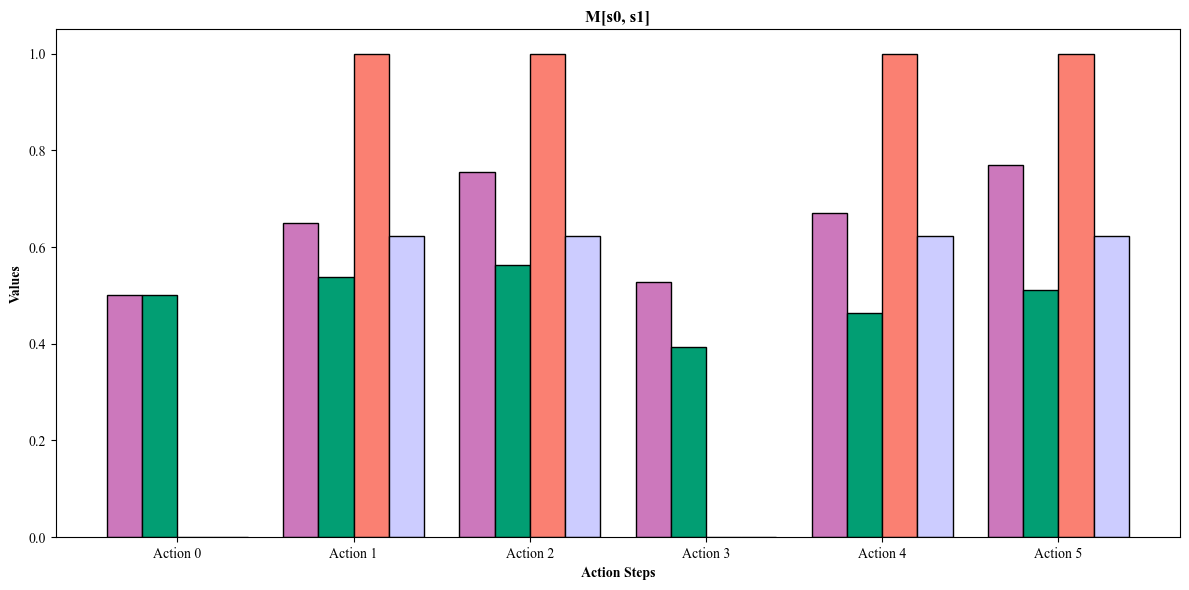

In [96]:
# Create the plots
plot_data(data_s0s1, 'M[s0, s1]', legend=False)

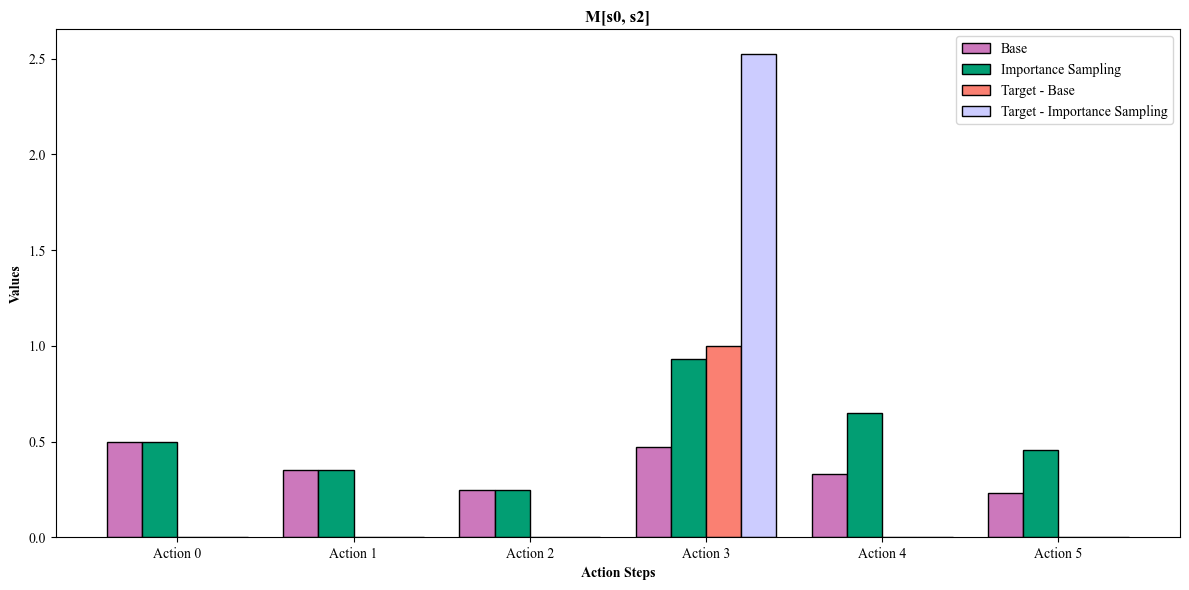

In [97]:
plot_data(data_s0s2, 'M[s0, s2]')